# H1975 batches analysis

## Dataprocessing
### Imports

In [1]:
import pandas as pdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from dbspro.notebook import *
from datetime import date
import scanpy as sc

sns.set_theme(style="whitegrid", font_scale=1.4)

sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white')
sc.settings.figdir = "../figures"

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.5.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


In [2]:
%matplotlib inline

In [3]:
# Functions
def today():
    return date.today().strftime("%y%m%d")

print(today())

def clr_normalize_adata(adata, on_cells=False, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""
    def seurat_clr(x):
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)
   
    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    if on_cells:
        adata.X = np.apply_along_axis(seurat_clr, 1, adata.X)
    else:
        x = np.array(adata.X)
        adata.X = np.log1p(np.divide(x, gmean(x[x>0], axis=0)))
    return adata


220516


### Data loading

In [4]:
# Load metadata
abc_target = pd.read_csv("../data/h1975.abc_target.csv", names=["abc", "target"]).set_index("abc").to_dict()["target"]
display(abc_target)
targets = list(abc_target.values())
display(targets)
sample_names= pd.read_csv("../data/h1975.samples.tsv", dtype=str, sep="\t")
samples = sorted(sample_names["Sample"].to_list())
display(samples)
display(sample_names)

{'ABC01': 'EGFR',
 'ABC12': 'Her2',
 'ABC09': 'CD9',
 'ABC03': 'CD3',
 'ABC18': 'PD-1',
 'ABC07': 'CD4',
 'ABC22': 'CD8',
 'ABC19': 'PD-L1',
 'ABC13': 'IGF-1R',
 'ABC14': 'NY-ESO1',
 'ABC16': 'EpCam'}

['EGFR',
 'Her2',
 'CD9',
 'CD3',
 'PD-1',
 'CD4',
 'CD8',
 'PD-L1',
 'IGF-1R',
 'NY-ESO1',
 'EpCam']

['H1975_1', 'H1975_2', 'H1975_3']

,Sample,Reads,FastqPath
0,H1975_1,1967979,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...
1,H1975_2,2611402,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...
2,H1975_3,2062477,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...


In [5]:
# Load data
data_raw = pd.read_csv("../data/h1975.tsv.gz", sep="\t")

# Rename ABCs to targets
data_raw.replace({"Target": abc_target}, inplace=True)

# Filter out UMIs with only one read count
print("Size before:", len(data_raw))
data_raw = data_raw[data_raw["ReadCount"] > 1]
print("Size after:", len(data_raw))

Size before: 1839593
Size after: 606650


### Overall QC

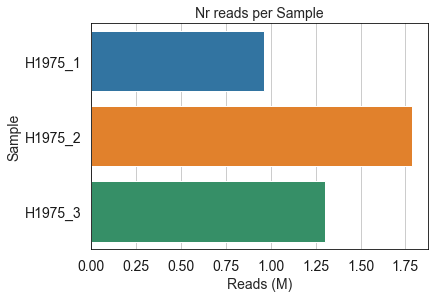

In [6]:
d = data_raw.groupby("Sample", as_index=False).sum()
d["ReadCount"] /= 1_000_000
ax = sns.barplot(data=d, y="Sample", x="ReadCount", order=samples)
_ = ax.set_xlabel("Reads (M)")
_ = ax.set_title("Nr reads per Sample")

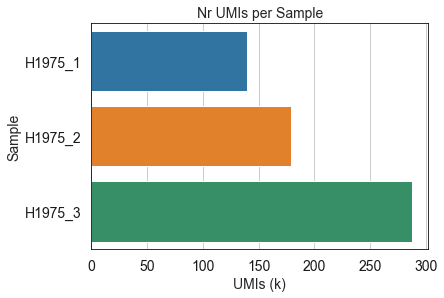

In [7]:
d = data_raw.groupby("Sample", as_index=False).count()
d["UMI"] /= 1_000
ax = sns.barplot(data=d, y="Sample", x="UMI", order=samples)
_ = ax.set_xlabel("UMIs (k)")
_ = ax.set_title("Nr UMIs per Sample")

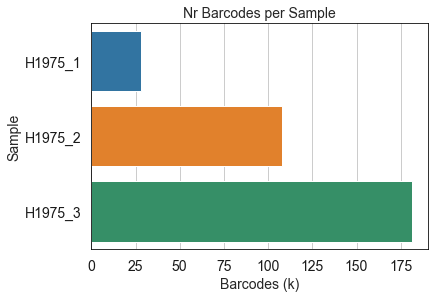

In [8]:
d = data_raw.groupby("Sample").agg({"Barcode":"nunique"})
d["Barcode"] /= 1_000
ax = sns.barplot(data=d, y=d.index, x="Barcode", order=samples)
_ = ax.set_xlabel("Barcodes (k)")
_ = ax.set_title("Nr Barcodes per Sample")

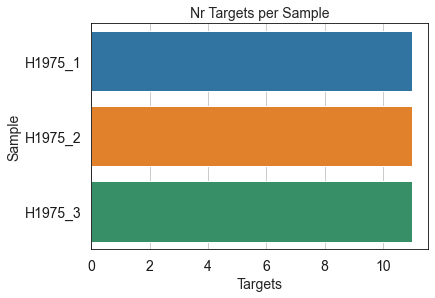

In [9]:
d = data_raw.groupby("Sample").agg({"Target":"nunique"})
ax = sns.barplot(data=d, y=d.index, x="Target", order=samples)
_ = ax.set_xlabel("Targets")
_ = ax.set_title("Nr Targets per Sample")

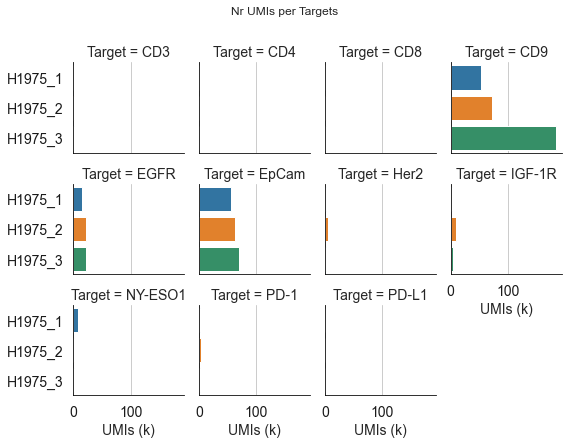

In [10]:
d = data_raw.groupby(["Sample", "Target"], as_index=False).agg({"UMI":"count"})
d["UMI"] /= 1000
g = sns.catplot(data=d, y="Sample", x="UMI",  col="Target", col_wrap=4, kind="bar", height=2)
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle("Nr UMIs per Targets")
_ = g.set_axis_labels("UMIs (k)", "")

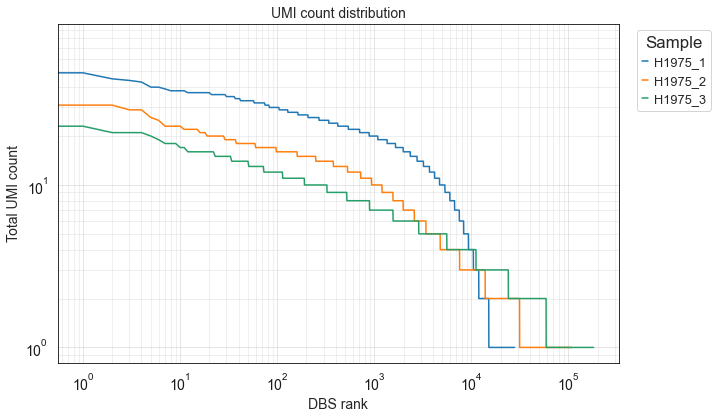

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("UMI count distribution")
for sample in samples:
    temp = data_raw[data_raw["Sample"] == sample].groupby("Barcode", as_index=False)["UMI"].count().sort_values(by="UMI",ascending=False).reset_index(drop=True)
    try:
        temp.plot(ax=ax, y="UMI", logx=True, logy=True, label=sample)
    except TypeError:
        pass
    
ax.set_xlabel("DBS rank")
ax.set_ylabel("Total UMI count")
ax.grid('on', which='major', axis='y', alpha=0.5 )
ax.grid('on', which='major', axis='x',alpha=0.5)
ax.grid('on', which='minor', axis='y', alpha=0.3)
ax.grid('on', which='minor', axis='x', alpha=0.3)
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Sample", loc='upper left')

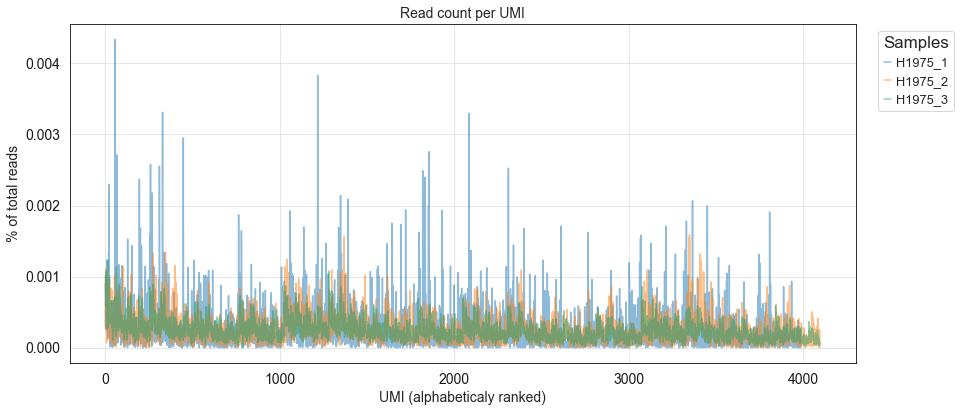

In [12]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_title("Read count per UMI")
for sample in samples:
    temp = data_raw[data_raw["Sample"] == sample].groupby("UMI", as_index=False)["ReadCount"].sum().sort_values(by="UMI",ascending=False).reset_index(drop=True)
    temp["GC"] = temp["UMI"].apply(lambda x: sum([c in {"G","C"} for c in x])/len(x)) 
    temp["ReadCount"] = temp["ReadCount"]/temp["ReadCount"].sum()
    try:
        temp.plot(ax=ax, y="ReadCount", logx=False, logy=False, label=sample, alpha=0.5)
    except TypeError:
        pass
ax.set_xlabel("UMI (alphabeticaly ranked)")
ax.set_ylabel("% of total reads")
ax.grid('on', which='major', axis='y', alpha=0.5 )
ax.grid('on', which='major', axis='x',alpha=0.5)
ax.grid('on', which='minor', axis='y', alpha=0.3)
ax.grid('on', which='minor', axis='x', alpha=0.3)
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Samples", loc='upper left')

(-5.0, 200.0)

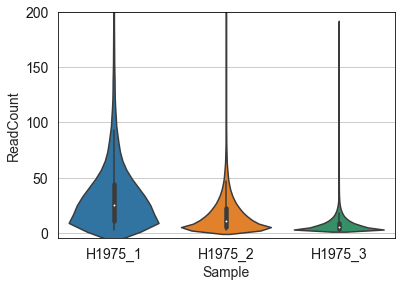

In [13]:
ax = sns.violinplot(data=data_raw.groupby(["Sample","Barcode"], as_index=False)["ReadCount"].sum(), kind="violin", x="Sample", y="ReadCount", bw_adjust=0.1, scale="width")
ax.set_ylim(-5,200)

## Filter and create count matrix

In [14]:
data_count = []
for sample in tqdm(samples):
    print(sample)
    d = data_raw[data_raw["Sample"]==sample]\
            .filter_rc(1)\
            .filter_uc(1)\
            .filter_ratio(2)\
            .filter_target_count(1)\
            .filter_dups_fast(0.5, min_len=2)
    data_count.append(d.to_matrix(qc=True).assign(Sample=sample))
    print("")
data_count = pd.concat(data_count)

  0%|          | 0/3 [00:00<?, ?it/s]

H1975_1
Filtering molecules per readcount gt 1
Barcodes = 27,857 (-0, -0.0%, runtime:0.015590190887451172 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 15,099 (-12,758, -45.8%, runtime:0.03693795204162598 s)
Filtering barcodes by Reads/UMI ratio gt 2
Barcodes = 12,116 (-2,983, -19.76%, runtime:0.042803049087524414 s)
Filtering for targets with UMI count gt 1
Barcodes = 11,439 (-677, -5.59%, runtime:0.036225080490112305 s)
Filter barcodes whose UMI + Target combos have a jaccard index >0.5
Barcodes = 9,187 (-2,252, -19.69%, runtime:8.669692993164062 s)

H1975_2
Filtering molecules per readcount gt 1
Barcodes = 107,656 (-0, -0.0%, runtime:0.028647184371948242 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 31,356 (-76,300, -70.87%, runtime:0.08313989639282227 s)
Filtering barcodes by Reads/UMI ratio gt 2
Barcodes = 26,302 (-5,054, -16.12%, runtime:0.060328006744384766 s)
Filtering for targets with UMI count gt 1
Barcodes = 17,485 (-8,817, -33.52%, runtime:0.0404243469

In [15]:
data_count.groupby("Sample").count()["total_count"]

Sample
H1975_1     9187
H1975_2    10058
H1975_3    30351
Name: total_count, dtype: int64

In [16]:
# Save counts to simply rerunning analysis from here.
data_count.to_csv("../data/h1975.counts.tsv.gz", sep="\t")

# Comment out the row above and run the code below if rerunning analysis
#data_count = pd.read_csv("../data/h1975.counts.tsv.gz", sep="\t").set_index("Barcode")

## Per Droplet QC

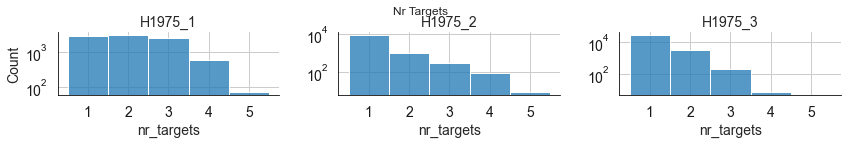

In [17]:
bins = np.array(range(1,data_count["nr_targets"].max()+1))

g = sns.displot(data_count, x="nr_targets", col="Sample", bins=bins, 
                height=2, aspect=2, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle("Nr Targets")
g.set(yscale="log", xticks = bins[:-1] + 0.5, xticklabels=bins[:-1])
g.set_titles("{col_name}")

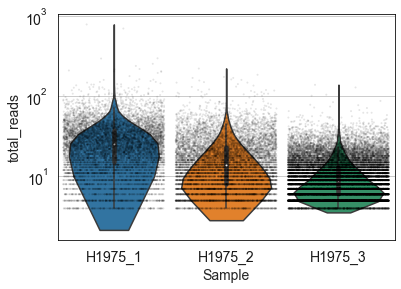

In [18]:
ax = sns.violinplot(data=data_count, y="total_reads", x="Sample", scale="width", cut=0.5)
ax = sns.stripplot(data=data_count, y="total_reads", x="Sample", size=2, jitter=0.45, color="black", alpha=0.1)

ax.set_yscale("log")

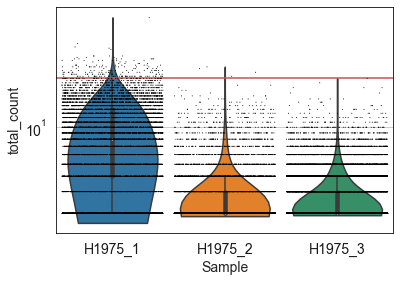

In [19]:
ax = sns.violinplot(data=data_count, y="total_count", x="Sample", bw=0.5, scale="width", cut=0.1)
ax = sns.stripplot(data=data_count, y="total_count", x="Sample", size=1, jitter=0.45, color="black")

ax.set_yscale("log")
ax.axhline(25, color="r")

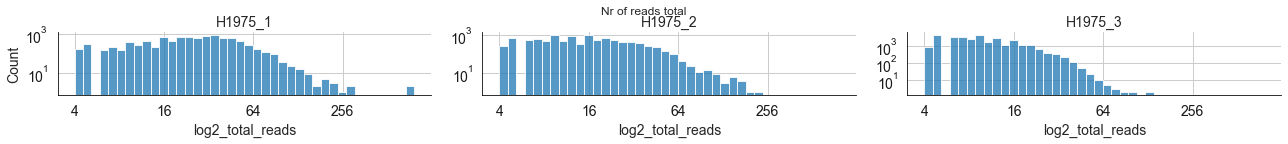

In [20]:
import matplotlib.ticker as tkr
d = data_count.copy()
d["log2_total_reads"] = np.log2(d["total_reads"])
g = sns.displot(d, x="log2_total_reads", col="Sample", col_wrap=3, bins=40,
                height=2, aspect=3, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle("Nr of reads total")
g.set(yscale="log", )
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: str(int(2**x))))

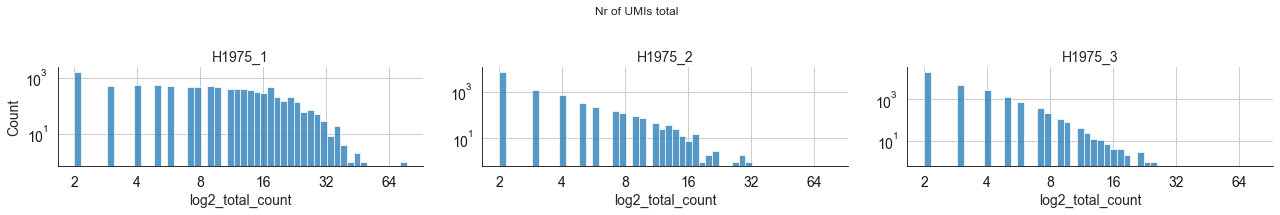

In [21]:
d = data_count.copy()
d["log2_total_count"] = np.log2(d["total_count"])
g = sns.displot(d, x="log2_total_count", col="Sample", col_wrap=3, bins=50,
                height=3, aspect=2, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.7)
_ = g.fig.suptitle("Nr of UMIs total")
g.set(yscale="log")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: str(int(2**x))))

## Filter data further

In [22]:
data_filt = data_count.groupby("Sample", as_index=False)\
    .apply(lambda x: x[(x["total_count"]>1) & (x["total_count"] < 25)])

In [23]:
# Get number of remaining droplets
data_filt.groupby("Sample").count()["total_count"]

Sample
H1975_1     8943
H1975_2    10054
H1975_3    30350
Name: total_count, dtype: int64

### Code for figure 3A

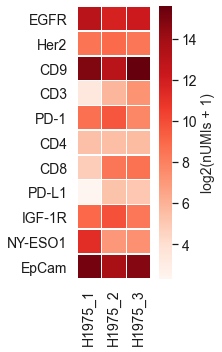

In [24]:
d = data_filt.copy()
d = d.loc[:,targets+ ["Sample"]]
fig, ax = plt.subplots(figsize=(3,5))
sns.heatmap(data=d.groupby("Sample").apply(lambda x: np.log2(x.sum()+1)).T, ax=ax,
           square=True, #annot=True, fmt='.0f', vmin=0,
           linewidths=.5, cmap="Reds", cbar_kws={"label":"log2(nUMIs + 1)"})
_ = plt.ylabel("")
_ = plt.xlabel("")
plt.tight_layout()

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_H1975_heatmap_targets_sum.{ext}", dpi=300)

### Code for figure 3B

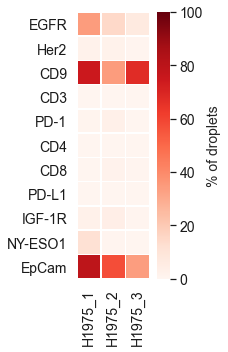

In [25]:
d = data_filt.copy()
d.loc[:,targets] = d.loc[:,targets].clip(upper=1)
d = d.loc[:,targets+ ["Sample"]]
fig, ax = plt.subplots(figsize=(3,5))
sns.heatmap(data=d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count()).T, ax=ax,
           square=True, vmin=0, vmax=100, #annot=True, fmt='.0f',
           linewidths=.5, cmap="Reds", cbar_kws={"label":"% of droplets"})
_ = plt.ylabel("")
_ = plt.xlabel("")
plt.tight_layout()

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_H1975_heatmap_targets.{ext}", dpi=300)

### Code for figure 3C

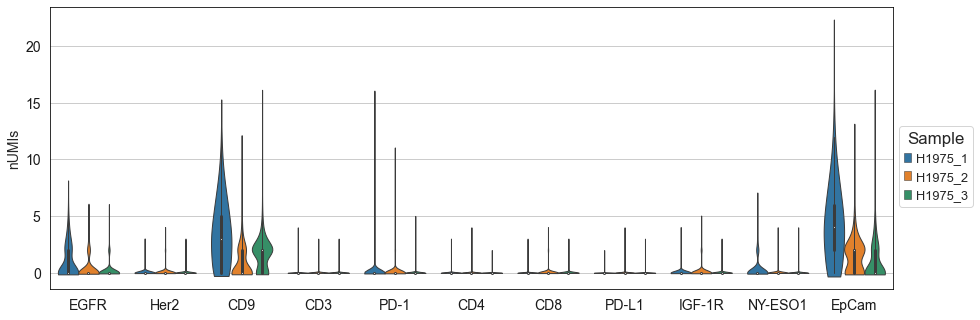

In [26]:
d = data_filt.melt(id_vars="Sample", value_vars=targets).copy()
#d = d[d["value"] > 0]
#d["value"] = np.log2(d["value"] + 1)
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.violinplot(ax=ax, data=d, x="Target", y="value", hue="Sample", 
                    scale="width", bw=0.5, cut=0.2, linewidth=1, inner="box") 
_ = ax.set_ylabel("nUMIs")
_ = ax.set_xlabel("")
_ = plt.legend(bbox_to_anchor=(1, 0.6), title="Sample", loc='upper left')

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_H1975_violinplots.{ext}", dpi=300)

### Code for supplemental table 3

In [27]:
# Total UMIs
d = data_filt.copy()
d = d.loc[:,targets + ["Sample"]]
d = d.groupby("Sample").sum().astype(int)
d["Total UMIs"] = d.sum(axis=1)
d.T

Sample,H1975_1,H1975_2,H1975_3
Target,,,
EGFR,8290,3450,4613
Her2,366,492,345
CD9,30468,8561,48996
CD3,10,57,154
PD-1,424,803,212
CD4,43,45,48
CD8,28,351,387
PD-L1,4,38,33
IGF-1R,503,915,344


In [28]:
# Percentage of total UMIs

d = data_filt.copy()
d = d.loc[:,targets + ["Sample"]]
d = d.groupby("Sample").sum().astype(int)
d = d.apply(lambda x: round(100 * x / x.sum(), 2), axis=1)
d.T

Sample,H1975_1,H1975_2,H1975_3
Target,,,
EGFR,10.33,11.81,5.55
Her2,0.46,1.68,0.41
CD9,37.95,29.30,58.93
CD3,0.01,0.20,0.19
PD-1,0.53,2.75,0.25
CD4,0.05,0.15,0.06
CD8,0.03,1.20,0.47
PD-L1,0.00,0.13,0.04
IGF-1R,0.63,3.13,0.41


## Scanpy analysis

In [29]:
d = data_filt.copy()
X = d.loc[:,targets].values
obs = d.loc[:, ["total_count", "total_reads", "nr_targets", "Sample"]].reset_index()
var = pd.DataFrame(index=targets)
adata = sc.AnnData(X, obs, var)

/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [30]:
adata

AnnData object with n_obs × n_vars = 49347 × 11
    obs: 'level_0', 'Barcode', 'total_count', 'total_reads', 'nr_targets', 'Sample'

normalizing counts per cell
    finished (0:00:00)


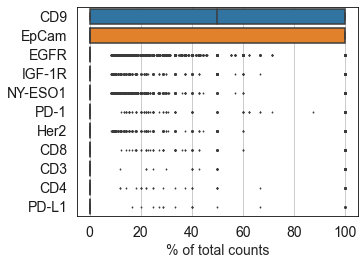

In [31]:
sc.pl.highest_expr_genes(adata, n_top=11, )

... storing 'Sample' as categorical


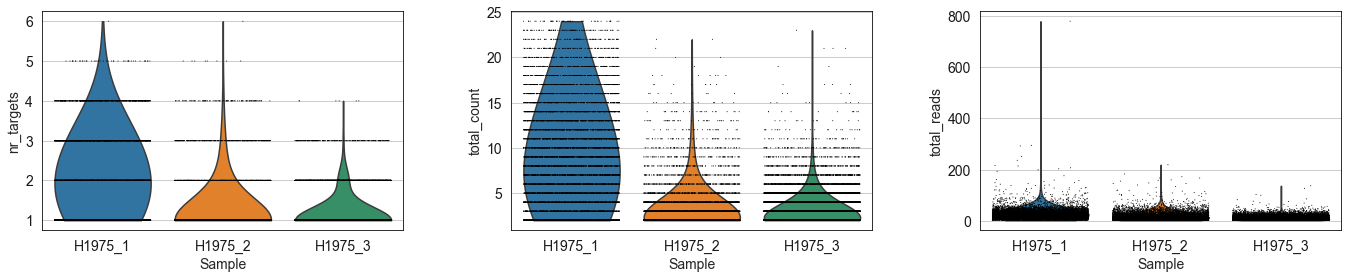

In [32]:
sc.pl.violin(adata, ['nr_targets', 'total_count', "total_reads"],
             jitter=0.4, multi_panel=True, bw=1, groupby="Sample")

In [33]:
target_counts = adata.var.copy()
target_counts["count"] = (adata.X != 0).sum(axis=0)

target_counts

,count
EGFR,6711
Her2,577
CD9,30683
CD3,108
PD-1,485
CD4,66
CD8,373
PD-L1,35
IGF-1R,835
NY-ESO1,1223


In [34]:
# Filter
sc.pp.filter_cells(adata, min_genes=3)

filtered out 45715 cells that have less than 3 genes expressed


In [35]:
# Calculate nr of remaining barcodes for each sample
adata.obs.groupby("Sample").count()["Barcode"]

Sample
H1975_1    2984
H1975_2     427
H1975_3     221
Name: Barcode, dtype: int64

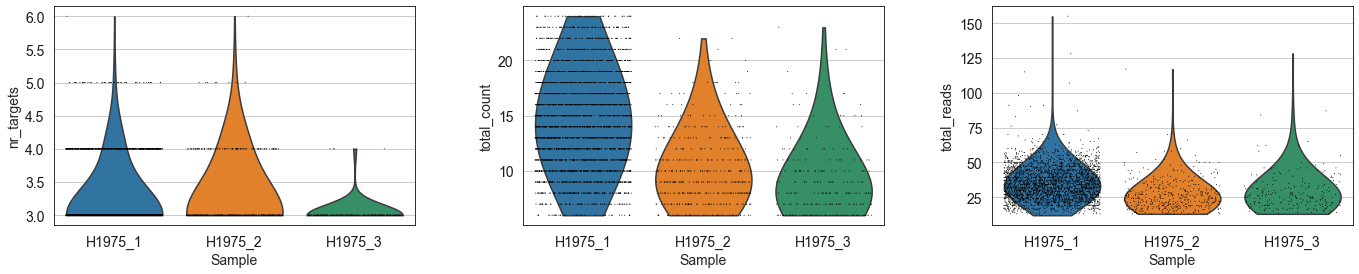

In [36]:
sc.pl.violin(adata, ['nr_targets', 'total_count', "total_reads"],
             jitter=0.4, multi_panel=True, bw=1, groupby="Sample")

In [37]:
# Normalize data
adata.raw = adata
for s in samples:
    clr_normalize_adata(adata[adata.obs.Sample == s, :], on_cells=False, inplace=True)

### PCA analysis

In [38]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=10
    finished (0:00:00)


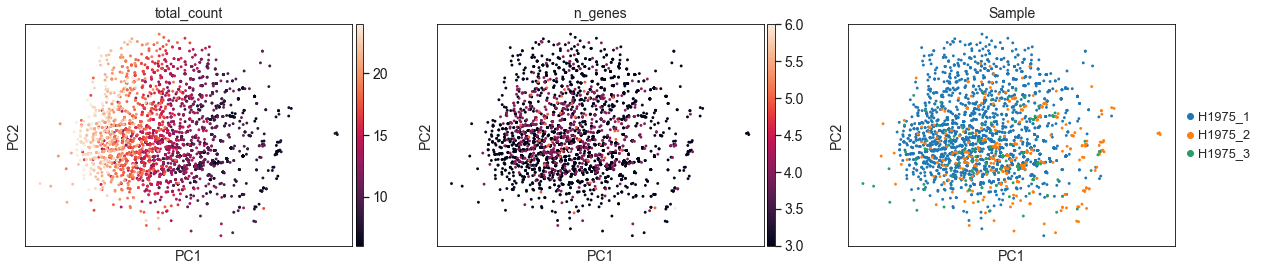

In [39]:
sc.pl.pca(adata, color=['total_count', "n_genes", 'Sample'], use_raw=False)

### Code for figure 3D

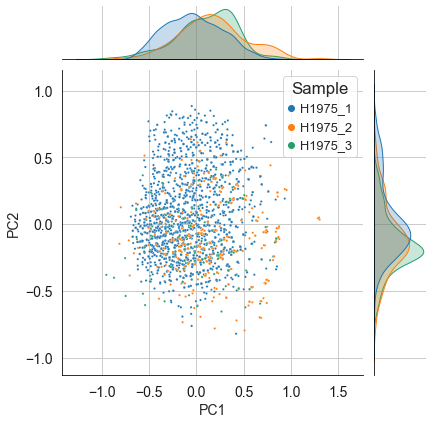

In [40]:
plotdf = sc.get.obs_df(adata, keys=["Sample"], obsm_keys=[("X_pca",0),("X_pca",1)])
plotdf.columns = ['Sample', 'PC1', 'PC2']
g = sns.jointplot(data=plotdf, x="PC1", y="PC2", hue="Sample", 
                  kind="scatter", s=5, marginal_kws={"common_norm": False})

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_H1975_pca_jointplot.{ext}", dpi=300)

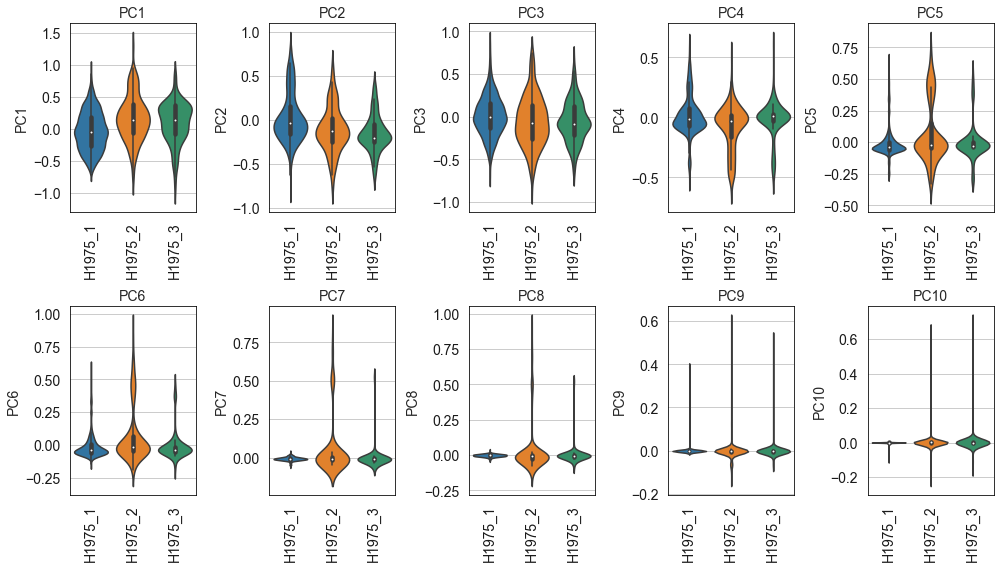

In [41]:
pcs = [f"PC{i}" for i in range(1, adata.obsm["X_pca"].shape[1]+1)]
df = pd.DataFrame(data = adata.obsm["X_pca"], columns=pcs)
df["Sample"] = adata.obs["Sample"].values

fig, axes = plt.subplots(nrows=2, ncols=len(pcs) // 2, figsize=(14,8))
for pc, ax in zip(pcs, axes.ravel()):
    ax = sns.violinplot(data=df, x="Sample", y=pc, ax=ax, scale="width")
    _ = ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(pc)
plt.tight_layout()

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_H1975_pca_comps_violin.{ext}", dpi=300)